In [1]:
# Converting layers to object
# initialise library
import numpy as np
import matplotlib as plt

print("Numpy:", np.__version__)
print("Matplotlib", plt.__version__)

!pip install nnfs

Numpy: 1.23.5
Matplotlib 3.7.2


* Consider a scenario with a neural network that performs classification between three classes, and
  the neural network classifies in batches of three. After running through the softmax activation
  function with a batch of 3 samples and 3 classes, the network’s output layer yields:
  
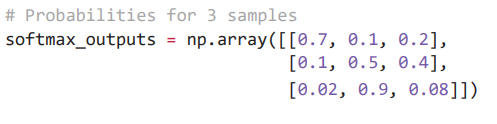

* We need a way to dynamically calculate the categorical cross-entropy, which we now know is a
  negative log calculation. To determine which value in the softmax output to calculate the negative
  log from, we simply need to know our target values. In this example, there are 3 classes; let’s say
  we’re trying to classify something as a “dog,” “cat,” or “human.” A dog is class 0 (at index 0), a
  cat class 1 (index 1), and a human class 2 (index 2). Let’s assume the batch of three sample inputs
  to this neural network is being mapped to the target values of a dog, cat, and cat. So the targets (as
  a list of target indices) would be [0, 1, 1].)
  
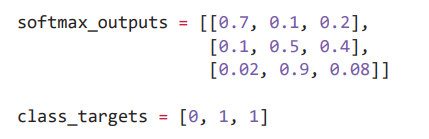



In [2]:
softmax_outputs = np.array([[0.7, 0.1, 0.2],    #0
                            [0.1, 0.5, 0.4],    #1
                            [0.02, 0.9, 0.08]]) #2
class_targets = [0, 1, 1]
#print(softmax_outputs[[0, 1, 2], class_targets])
# you can do this as well and wrap it with log
# result of the output will be our losses
print(-np.log(softmax_outputs[range(len(softmax_outputs)), class_targets]))

[0.35667494 0.69314718 0.10536052]


In [3]:
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()


# We are going to code our hidden layer
# The reason is called a hidden layer because we as a programmer is not in charge of that layer

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # it is convention to set the weights to be small between 0 & 1
        # setting our weights to be between 0 to 1 hence 0.1*random()
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons) 
        self.biases = np.zeros((1, n_neurons)) # passing the shape, (()) is a tuple
    def foward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        
# our activation function        
class Activation_Relu:
    def foward(self, inputs):
        self.output = np.maximum(0, inputs)
        
# np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) is to prevent overflow        
class Activation_Softmax:
    def foward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
# we are going to implement the loss class
class Loss:
    def calculate(self, output, y):
        sample_losses = self.foward(output, y)
        data_loss = np.mean(sample_losses) # batch loss
        return data_loss
    
class Loss_CategoricalCrossentropy(Loss): # this class inherits from base loss class
    def foward(self, y_pred, y_true):
        samples = len(y_pred)
        # we are going to clip this values
        # values are clipped to prevent overflow. log 0 = infinity
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        # handle one hot encoding values
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
# Define our data
X, y = spiral_data(samples=100, classes=3)

# We have to input features XY therefore input is 2
# The output can be any values you want, in this case we choose 3
dense1 = Layer_Dense(2,3)

activation1 = Activation_Relu()

# output in our previous layer is 3, then our input must be 3
dense2 = Layer_Dense(3, 3) # treating this as our output layer

activation2 = Activation_Softmax()

dense1.foward(X)
activation1.foward(dense1.output)

dense2.foward(activation1.output)
activation2.foward(dense2.output)

#print(activation2.output)
print(activation2.output[:5]) # print first 5, since we have 300 samples

loss_function = Loss_CategoricalCrossentropy()
loss = loss_function.calculate(activation2.output, y)
print("Loss:", loss)

[[0.33333334 0.33333334 0.33333334]
 [0.33331734 0.3333183  0.33336434]
 [0.3332888  0.33329153 0.33341965]
 [0.33325943 0.33326396 0.33347666]
 [0.33323312 0.33323926 0.33352762]]
Loss: 1.098445
